<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Pneumonia_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia Classification Challenge by Segmind

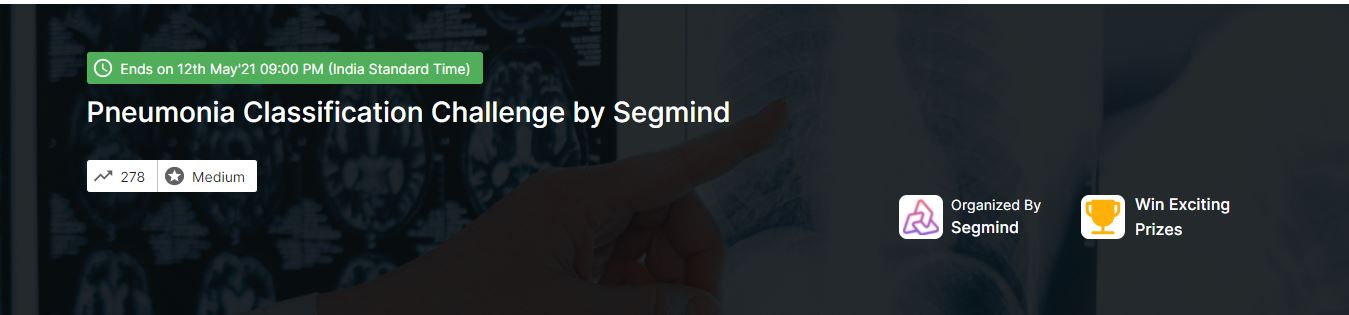

## About the Dataset

* It consists of 2425 CXRs for training and 606 CXRs for testing. Training data: 1145 Pneumonia CXRs and 1280 Normal CXRs. Every CXR is a 1024 X 1024 image in the PNG format.

* The labels for each CXR were extracted using an NLP label extractor from corresponding radiology reports.


 

Download the dataset from here: https://drive.google.com/file/d/1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY/view?usp=sharing

 

From the above link you will be able to download a zip file named detect_trees_near_electric_wires.zip’. After you extract this zip file, you will get four files:

* train - contains all the images that are to be used for training your model.
 

* test - contains 600+ images. For these images you are required to make predictions whether  the x-ray image is disease
 

* test.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you submit are with their image’s filename in the same order as given in this file.
 

* sample_submission: This is a csv file that contains the sample submission for the data sprint.

**Note: The header of the predicted values in the submission file to be ‘label’ else it will throw an error. For reference check sample submission file downloaded from above link.**

## Problem Statement
 
Pneumonia Classification in Chest X-Rays (CXRs) is organized by Segmind. As you maybe aware, "Pneumonia killed more than 808,000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years. People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems." — WHO 

 

While prevalent, diagnosing pneumonia in a CXR accurately is difficult. Expert radiologists are required to review the CXR and also require confirmation through clinical examinations. You are tasked to classify CXRs with pneumonia from their normal CXR counterparts, using machine learning and computer vision techniques.

## Evaluation Metrics : F1_Score

## Download Images

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

## Building Montages of the Training Images

In [3]:
from imutils import build_montages
from imutils import paths
import argparse
import random
import cv2

## grab the paths to the images, then randomly select a sample of them

In [4]:
imagePaths = list(paths.list_images("/content/content/pneumonia_dataset/train/"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:21]

## Read a sample imges and find the shape of the images

In [5]:
img = cv2.imread(imagePaths[0])
img.shape

(1024, 1024, 3)

In [6]:
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
	# load the image and update the list of images
	image = cv2.imread(imagePath)
	images.append(image)
# construct the montages for the images
montages = build_montages(images, (224, 224), (7, 3))

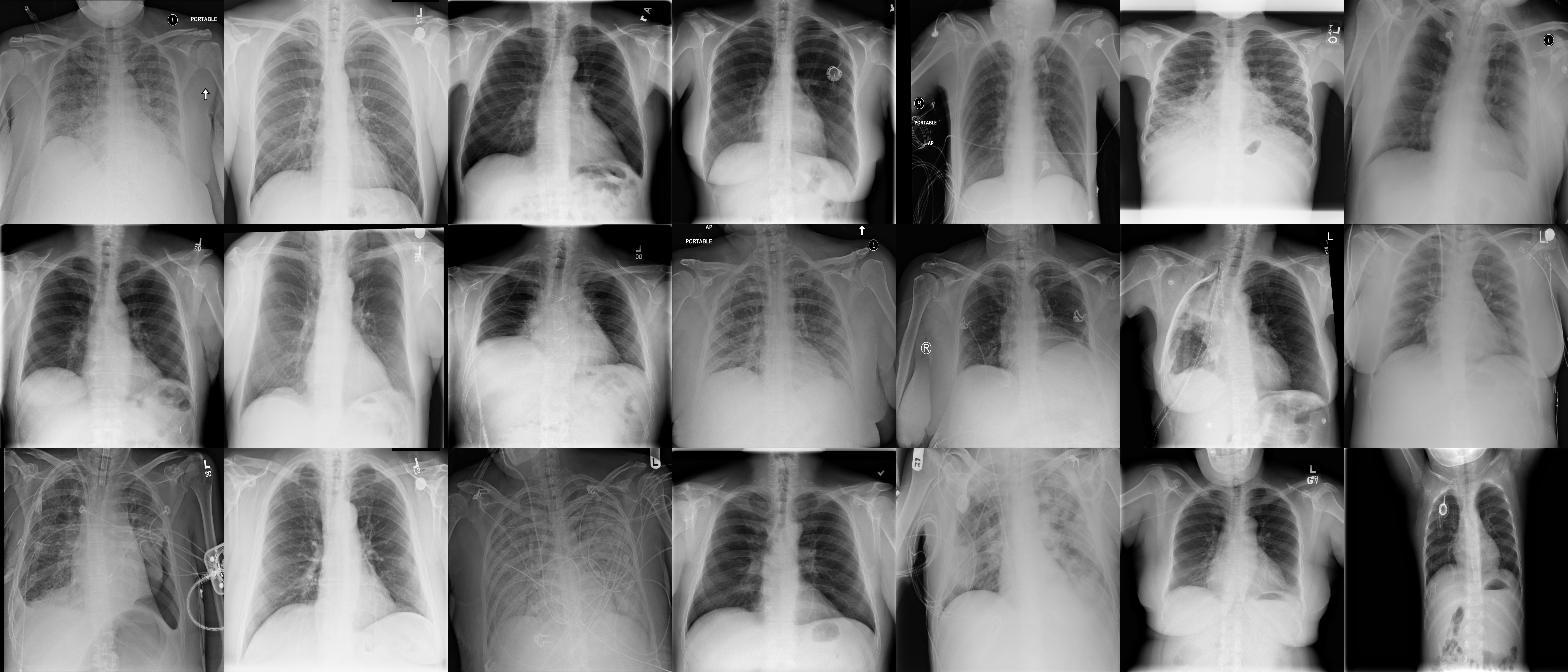

In [7]:
# loop over the montages and display each of them
from google.colab.patches import cv2_imshow
for montage in montages:
	cv2_imshow(montage)

## Import Required Libraries

In [8]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import glob
#
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
#

import warnings
warnings.filterwarnings('ignore')

## Prepare Trtaining File

In [23]:
image_folder = os.listdir("/content/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/content/pneumonia_dataset/train",folder)):
    filename.append("train/"+folder+"/"+image_name)
    label.append(folder)


## Preapare a Dataframe

In [24]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

,filename,label
0,train/pneumonia/CXR_train_435.png,pneumonia
1,train/pneumonia/CXR_train_192.png,pneumonia
2,train/pneumonia/CXR_train_63.png,pneumonia
3,train/pneumonia/CXR_train_651.png,pneumonia
4,train/pneumonia/CXR_train_732.png,pneumonia


## Visualize the Labels

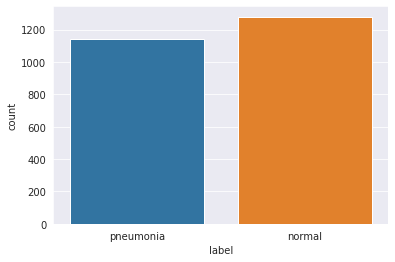

In [15]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

* Labels are balanced - no scenario of imbalance

## Export the dataframe to a .csv file

In [25]:
train_df.to_csv("/content/content/pneumonia_dataset/Training.csv",index=False)

## Prepare Data

In [26]:
path ='/content/content/pneumonia_dataset/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/content/pneumonia_dataset/Training.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/content/pneumonia_dataset/test')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

## Show Data

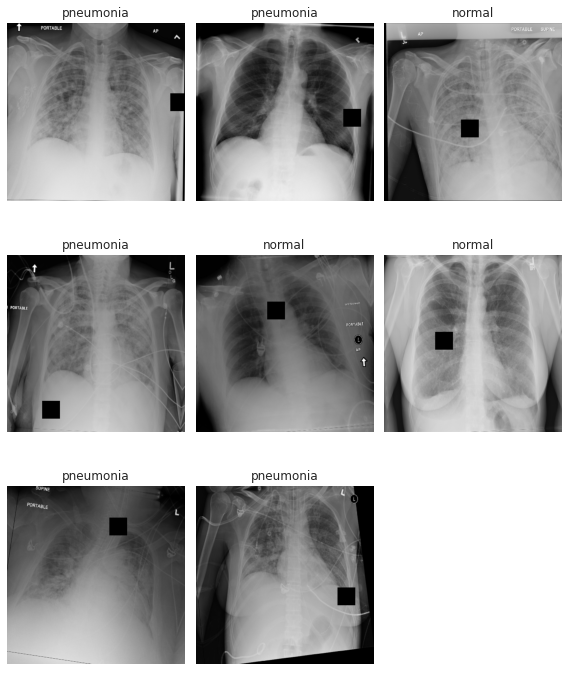

In [27]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

## print the target classes

In [28]:
val=data.classes
print(f"The number of target class : {data.c} and the respective target classes are a: {data.classes}")

The number of target class : 2 and the respective target classes are a: ['normal', 'pneumonia']


## Data Image Definition

In [29]:
data

ImageDataBunch;

Train: LabelList (1940 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/content/pneumonia_dataset;

Valid: LabelList (485 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
pneumonia,normal,normal,normal,pneumonia
Path: /content/content/pneumonia_dataset;

Test: LabelList (606 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: EmptyLabelList
,,,,
Path: /content/content/pneumonia_dataset

## Define F1 metrics 

In [45]:
fscore = FBeta(average='macro', beta=1)

In [46]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy,fscore])

In [49]:
learn2 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy,fscore])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [47]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.890061,0.644477,0.334021,0.665979,0.664609,02:55


In [50]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.896923,0.663660,0.319588,0.680412,0.672795,03:22


In [51]:
path= '/content/content/pneumonia_dataset/'
k= '/content/content/pneumonia_dataset/Training.csv'
p ='/content/content/pneumonia_dataset/test.csv'
#
train=pd.read_csv(k)
test=pd.read_csv(p)

In [52]:
train.head()

,filename,label
0,train/pneumonia/CXR_train_435.png,pneumonia
1,train/pneumonia/CXR_train_192.png,pneumonia
2,train/pneumonia/CXR_train_63.png,pneumonia
3,train/pneumonia/CXR_train_651.png,pneumonia
4,train/pneumonia/CXR_train_732.png,pneumonia


In [53]:
test.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


## Set the Path

In [54]:
np.random.seed(1786)
ROOT = "/content/content/pneumonia_dataset"

In [55]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

## Define a Callback function to save the best model

In [56]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

## Train the model and evaluate on validation set and Predict on the test data for 5 Epochs

In [59]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(5):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #print(data)
        learn = cnn_learner(data, models.resnet152, metrics=[accuracy,fscore],ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(2)
        learn.unfreeze()
        learn.fit_one_cycle(2, max_lr=1e-4, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.170468,0.795305,0.684211,0.682838,01:32
1,0.816040,0.613417,0.664474,0.664110,01:31


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.693303,0.641332,0.638158,0.634599,01:34
1,0.648165,0.672679,0.684211,0.682838,01:33


Save the best acc 0.63816
Save the best acc 0.68421


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.592125,0.662867,0.677632,0.677282,01:33
1,0.613917,0.667501,0.690789,0.690776,01:32


Save the best acc 0.67763
Save the best acc 0.69079


F1 score for this fold  0.7226780319969336


Starting fold 1
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.204671,0.771145,0.651316,0.641621,01:24
1,0.820084,0.693043,0.657895,0.656944,01:23


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.718955,0.600892,0.717105,0.714323,01:26
1,0.635897,0.581756,0.743421,0.743143,01:26


Save the best acc 0.71711
Save the best acc 0.74342


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.595684,0.577507,0.763158,0.762788,01:25
1,0.602820,0.578754,0.750000,0.749610,01:26


Save the best acc 0.76316


F1 score for this fold  0.7959729058127227


Starting fold 2
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.140730,0.937463,0.598684,0.598249,01:22
1,0.791782,0.712760,0.671053,0.670996,01:22


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.679991,0.684028,0.657895,0.650575,01:25
1,0.640458,0.686589,0.664474,0.662707,01:23


Save the best acc 0.65789
Save the best acc 0.66447


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.599714,0.678285,0.657895,0.654062,01:23
1,0.589886,0.678030,0.651316,0.648746,01:23


Save the best acc 0.65789
Save the best acc 0.65132


F1 score for this fold  0.6578947368421053


Starting fold 3
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.253068,0.812248,0.657895,0.653029,01:23
1,0.854562,0.620366,0.684211,0.680672,01:23


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.705143,0.642918,0.690789,0.684773,01:25
1,0.649762,0.582375,0.717105,0.715616,01:24


Save the best acc 0.69079
Save the best acc 0.71711


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.605028,0.572597,0.717105,0.716110,01:24
1,0.606531,0.561452,0.717105,0.716799,01:25


Save the best acc 0.71711
Save the best acc 0.71711


F1 score for this fold  0.7696468291433967


Starting fold 4
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.206770,0.936748,0.546053,0.542708,01:26
1,0.844392,0.729356,0.631579,0.631324,01:24


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.701124,0.760393,0.631579,0.630556,01:25
1,0.648371,0.691361,0.651316,0.650089,01:25


Save the best acc 0.63158
Save the best acc 0.65132


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.588830,0.703691,0.644737,0.640756,01:24


epoch,train_loss,valid_loss,accuracy,f_beta,time
epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.588830,0.703691,0.644737,0.640756,01:24
1,0.607507,0.689506,0.657895,0.656944,01:25


Save the best acc 0.65789


F1 score for this fold  0.671280592333224


In [60]:
test_df.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


In [61]:
sub = test_df[["filename"]]
sub["label"] = np.argmax(test_preds, axis=1)

In [62]:
val

['normal', 'pneumonia']

In [63]:
sub['label'] = sub['label'].apply(lambda x : val[x])

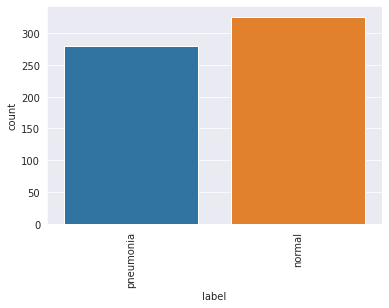

In [64]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.show()

In [65]:
sub.to_csv("submission_resnet152.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_resnet152.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Submission successful! Your score is 71.95899139518333.**

## Densenet121

In [67]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(5):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,time
0,1.199670,0.970147,0.638158,01:23
1,0.887550,0.641440,0.657895,01:23
2,0.711182,0.613434,0.697368,01:23
3,0.625011,0.587357,0.717105,01:24


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.591325,0.586832,0.684211,01:25
1,0.578806,0.540347,0.710526,01:25
2,0.584733,0.581182,0.703947,01:25
3,0.563767,0.646248,0.677632,01:24
4,0.543847,0.644795,0.657895,01:24
5,0.521940,0.589471,0.697368,01:24
6,0.492074,0.563134,0.723684,01:24
7,0.471392,0.571293,0.717105,01:22
8,0.455666,0.569249,0.717105,01:21


Save the best acc 0.68421
Save the best acc 0.71053
Save the best acc 0.72368


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.435943,0.565994,0.723684,01:23
1,0.440186,0.588431,0.703947,01:25
2,0.432555,0.616302,0.736842,01:24
3,0.430834,0.586444,0.677632,01:24
4,0.403055,0.594584,0.690789,01:25
5,0.393477,0.602426,0.697368,01:23
6,0.347481,0.642296,0.671053,01:23
7,0.329855,0.649619,0.684211,01:24
8,0.306073,0.650944,0.703947,01:23


Save the best acc 0.73684
Save the best acc 0.67763
Save the best acc 0.69079
Save the best acc 0.69737
Save the best acc 0.70395
Save the best acc 0.69737


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.315013,0.654651,0.690789,01:23
1,0.314511,0.650748,0.697368,01:23
2,0.315826,0.665667,0.697368,01:23
3,0.298267,0.681915,0.697368,01:23
4,0.304925,0.679716,0.703947,01:23
5,0.288683,0.692914,0.703947,01:23
6,0.279033,0.699968,0.703947,01:22
7,0.271790,0.703357,0.703947,01:24
8,0.269788,0.703002,0.703947,01:24


Save the best acc 0.70395


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.315013,0.654651,0.690789,01:23
1,0.314511,0.650748,0.697368,01:23
2,0.315826,0.665667,0.697368,01:23
3,0.298267,0.681915,0.697368,01:23
4,0.304925,0.679716,0.703947,01:23
5,0.288683,0.692914,0.703947,01:23
6,0.279033,0.699968,0.703947,01:22
7,0.271790,0.703357,0.703947,01:24
8,0.269788,0.703002,0.703947,01:24


Save the best acc 0.71053


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.278882,0.699801,0.703947,01:23
1,0.276117,0.699255,0.723684,01:23
2,0.262379,0.714031,0.723684,01:23
3,0.267461,0.696950,0.723684,01:23
4,0.275648,0.704795,0.717105,01:22
5,0.266541,0.726779,0.710526,01:23
6,0.256368,0.720614,0.730263,01:23
7,0.257226,0.714814,0.717105,01:24
8,0.246325,0.723259,0.710526,01:24


Save the best acc 0.70395
Save the best acc 0.72368
Save the best acc 0.72368
Save the best acc 0.73026
Save the best acc 0.71711
Save the best acc 0.71711


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.256125,0.717686,0.717105,01:23
1,0.251411,0.717371,0.717105,01:23
2,0.244241,0.723829,0.723684,01:23
3,0.244246,0.720985,0.717105,01:23
4,0.244112,0.716486,0.730263,01:23
5,0.241524,0.717122,0.717105,01:23
6,0.245073,0.717195,0.717105,01:22


Save the best acc 0.72368
Save the best acc 0.71711


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd92c1898c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd92c1898c0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Save the best acc 0.73026


F1 score for this fold  0.7041396520094347


Starting fold 1
(2273,) (152,)


epoch,train_loss,valid_loss,accuracy,time
0,1.164951,0.921667,0.664474,01:22
1,0.860678,0.629554,0.723684,01:22
2,0.709320,0.596871,0.703947,01:22
3,0.634686,0.584841,0.697368,01:22


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.599569,0.576613,0.717105,01:23
1,0.574588,0.574163,0.730263,01:23
2,0.584319,0.566028,0.730263,01:23
3,0.570661,0.519593,0.769737,01:22
4,0.552702,0.555607,0.710526,01:23
5,0.521095,0.534433,0.697368,01:22
6,0.503351,0.528300,0.763158,01:22
7,0.488063,0.511818,0.736842,01:23
8,0.463291,0.509085,0.769737,01:23


Save the best acc 0.71711
Save the best acc 0.73026
Save the best acc 0.73026
Save the best acc 0.76974
Save the best acc 0.73684
Save the best acc 0.76974


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.463538,0.510638,0.723684,01:22
1,0.448229,0.512025,0.763158,01:22
2,0.436734,0.535961,0.730263,01:23
3,0.448542,0.555679,0.710526,01:23
4,0.435104,0.534097,0.697368,01:23
5,0.402628,0.561900,0.736842,01:22
6,0.371040,0.562268,0.736842,01:23
7,0.351397,0.566222,0.743421,01:23
8,0.317737,0.564512,0.743421,01:22


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.315514,0.571445,0.756579,01:23
1,0.304493,0.579515,0.743421,01:23
2,0.312317,0.595545,0.723684,01:23
3,0.316829,0.576546,0.736842,01:23
4,0.318556,0.596390,0.750000,01:23
5,0.292148,0.578376,0.743421,01:22
6,0.283725,0.595225,0.750000,01:23
7,0.295198,0.591827,0.743421,01:22
8,0.287598,0.585566,0.756579,01:23


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.280509,0.591200,0.736842,01:23
1,0.277863,0.597150,0.750000,01:22
2,0.280525,0.590349,0.750000,01:23
3,0.284262,0.591796,0.763158,01:23
4,0.279297,0.606710,0.736842,01:24
5,0.287227,0.612158,0.743421,01:23


KeyboardInterrupt: ignored

In [68]:
sub = test_df[["filename"]]
sub["label"] = np.argmax(test_preds, axis=1)

In [69]:
sub['label'] = sub['label'].apply(lambda x : val[x])

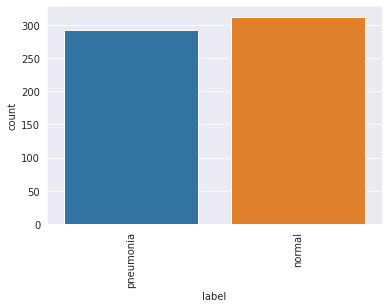

In [70]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.show()

In [71]:
sub.to_csv("submission_dense121.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_dense121.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Submission successful! Your score is 78.62044210463343.- Densenet121-2 epochs each epoch having 10 fit cycles**